In [801]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

dataset: https://www.kaggle.com/camnugent/california-housing-prices
  we will predict median house value

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [802]:
ocean_proximities = ['NEAR BAY', 'INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND']
houses_df = pd.read_csv("housing.csv", converters={
    "ocean_proximity": lambda val: ocean_proximities.index(val),})

houses_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


In [803]:
# how much each attribute correlates with the median house value
corr_matrix = houses_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
ocean_proximity       0.203778
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

replace zero values with median

In [804]:
houses_df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [805]:
median = houses_df['total_bedrooms'].median()
houses_df['total_bedrooms'] = houses_df['total_bedrooms'].fillna(median)
houses_df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

taking log to get normal distribution

In [806]:
houses_df['total_bedrooms_log'] = np.log2(houses_df['total_bedrooms'])
houses_df['total_rooms_log'] = np.log2(houses_df['total_rooms'])
houses_df['households_log'] = np.log2(houses_df['households'])
houses_df['population_log'] = np.log2(houses_df['population'])
houses_df = houses_df.drop(['population', 'households', 'total_rooms', 'total_bedrooms'],axis = 1)

normalizing whole df

In [807]:
def prepare_df(data):
    col_names = list(data.columns)
    for i in range(len(col_names)):
        feature_name = col_names[i]
        data[f'{feature_name}'] = MinMaxScaler().fit_transform(np.array(data[f'{feature_name}']).reshape(-1,1))
    return data

houses_prepared = prepare_df(houses_df)

finding & removing outliers

In [808]:
def no_outliers(data, cols):
    for col in cols:
        upper = data[f'{col}'].mean() + 3*houses_prepared[f'{col}'].std()
        lower = data[f'{col}'].mean() - 3*houses_prepared[f'{col}'].std()
        data = data.drop(data[(data[f'{col}'] < lower) | (data[f'{col}'] > upper)].index)
    return data

# cols_to_clean = ['households_log', 'median_income', 'population_log', 'total_rooms_log', 
#                  'total_bedrooms_log', 'latitude', 'longitude']
cols_to_clean = list(houses_prepared.columns)
houses_prepared = no_outliers(houses_prepared, cols_to_clean)

In [809]:
houses_prepared

,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity,total_bedrooms_log,total_rooms_log,households_log,population_log
0,0.211155,0.567481,0.784314,0.539668,0.902266,0.00,0.554074,0.615675,0.555059,0.498300
1,0.212151,0.565356,0.392157,0.538027,0.708247,0.00,0.799049,0.826854,0.807639,0.712402
2,0.210159,0.564293,1.000000,0.466028,0.695051,0.00,0.598220,0.667368,0.594066,0.544339
3,0.209163,0.564293,1.000000,0.354699,0.672783,0.00,0.622454,0.653100,0.618503,0.556891
4,0.209163,0.564293,1.000000,0.230776,0.674638,0.00,0.642430,0.677839,0.637756,0.558219
...,...,...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.073130,0.130105,0.25,0.675432,0.680174,0.665561,0.601114
20636,0.312749,0.738576,0.333333,0.141853,0.128043,0.25,0.571269,0.592093,0.543573,0.508997
20637,0.311753,0.732200,0.313725,0.082764,0.159383,0.25,0.705063,0.710810,0.696738,0.619805
20638,0.301793,0.732200,0.333333,0.094295,0.143713,0.25,0.685632,0.691377,0.671986,0.587118


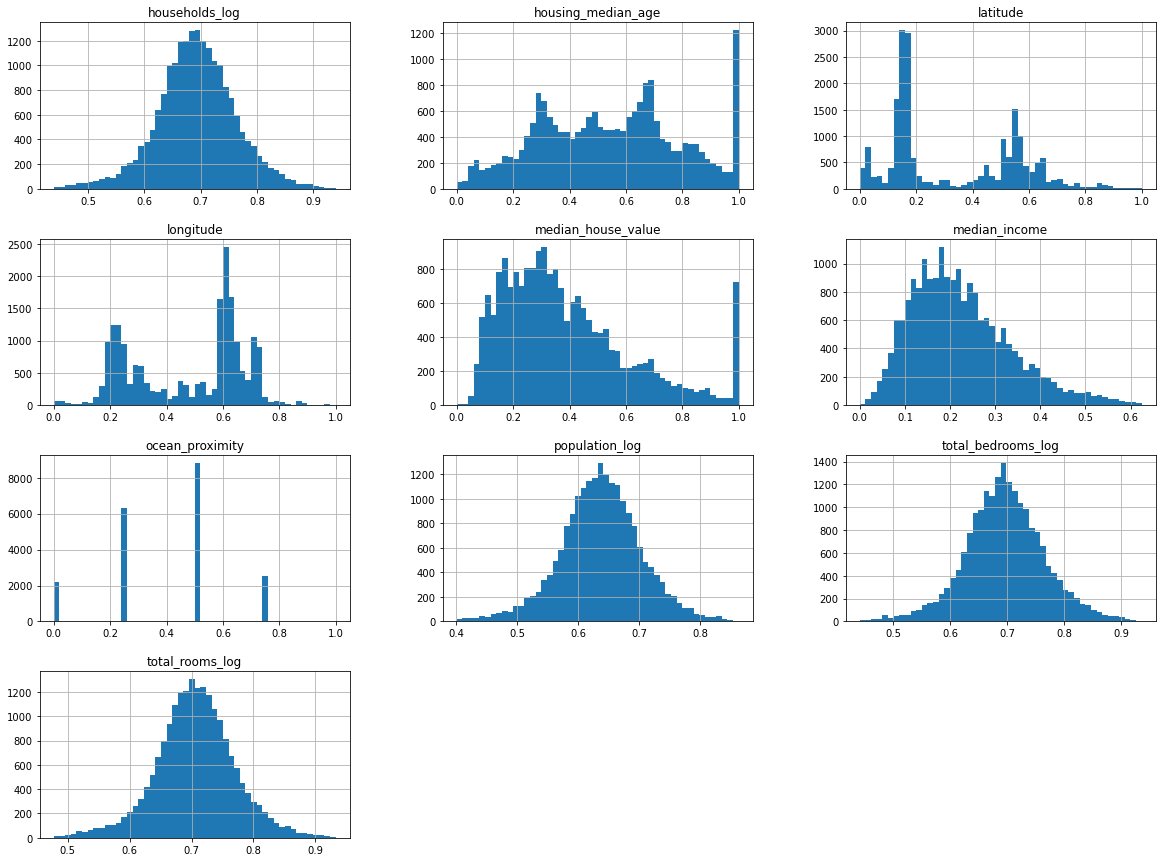

In [810]:
houses_prepared.hist(bins = 50, figsize = (20,15))
plt.show()

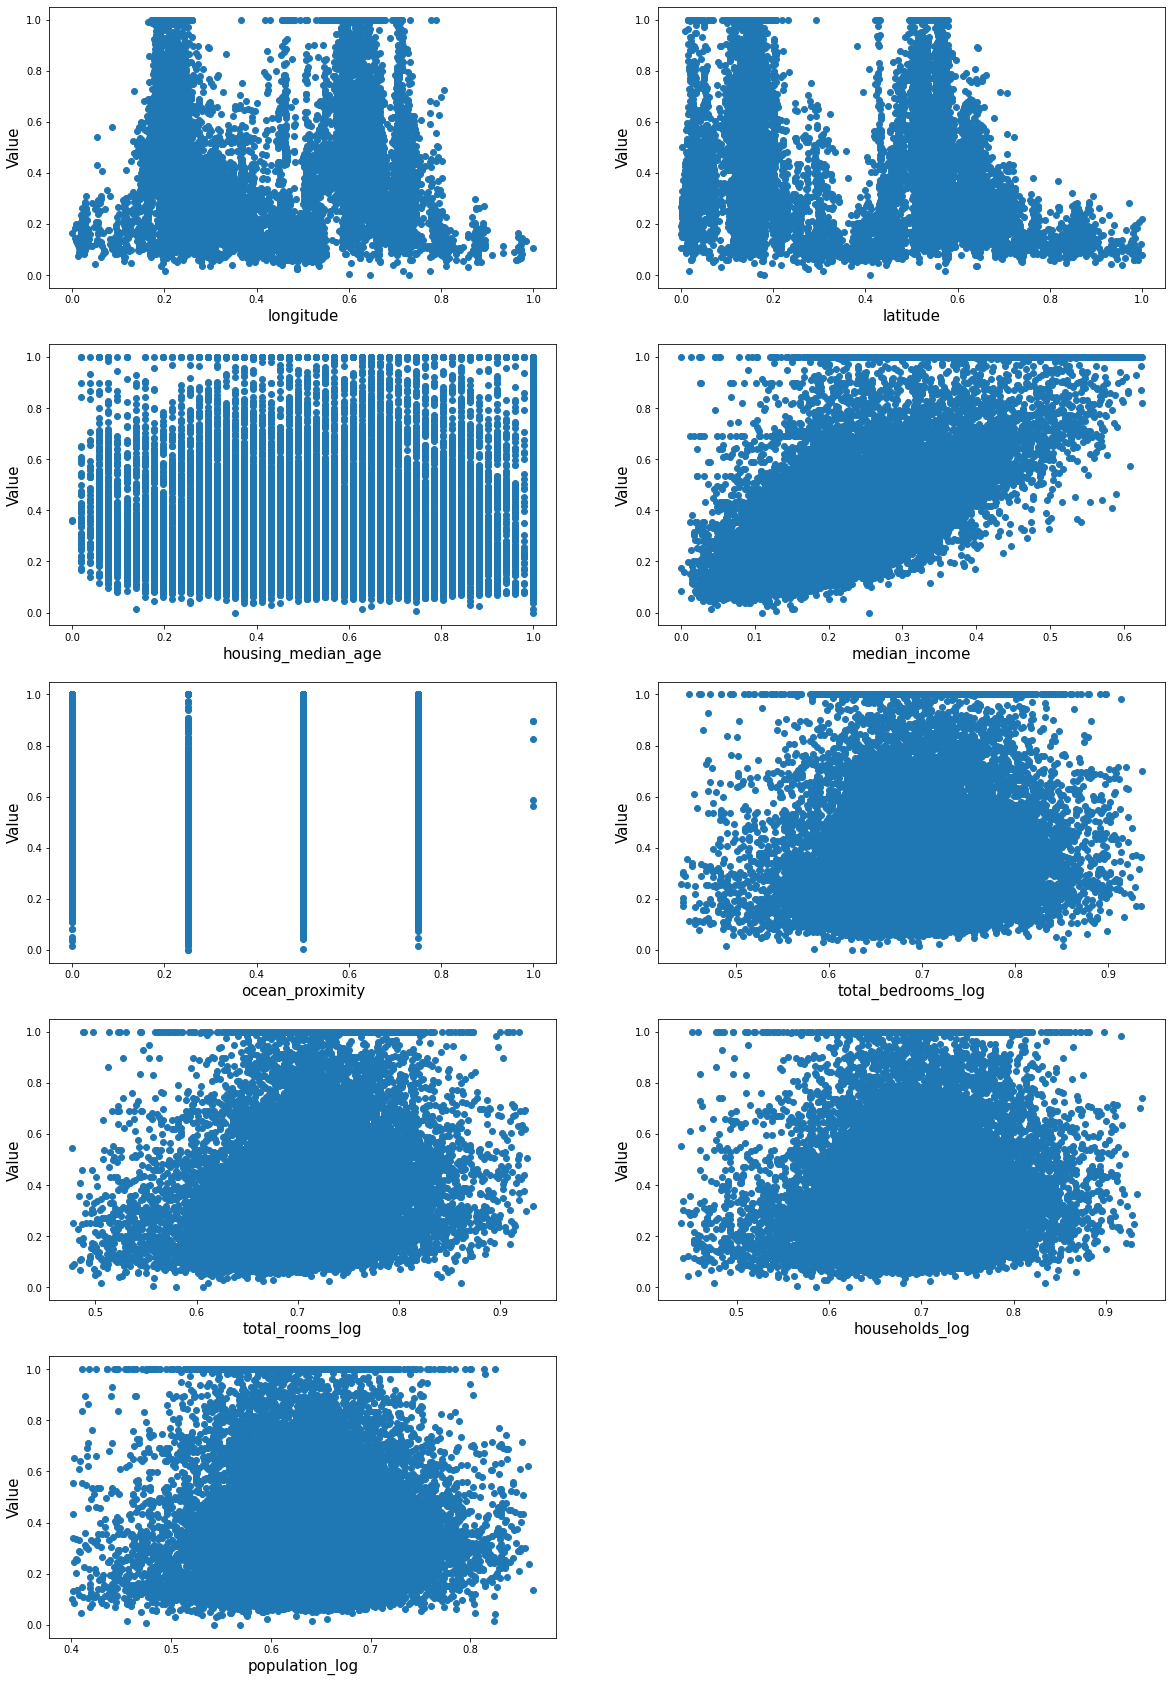

In [811]:
plt.figure(figsize=(20, 30))
col_names = list(X.columns)
for i in range(len(col_names)):
    plt.subplot(5, 2, i+1)
    feature_name = col_names[i]
    plt.scatter(X[f'{feature_name}'], Y)
    plt.ylabel("Value", size=15)
    plt.xlabel(feature_name, size=15)
#     plt.tight_layout()

Regression

In [812]:
Y = houses_prepared['median_house_value'].astype('float32')
X = houses_prepared.drop(['median_house_value'],axis = 1).astype('float32')
print(X.shape, Y.shape)

(19893, 9) (19893,)


In [813]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)

In [814]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
r2 = r2_score(y_test,pred)

model_Lasso = Lasso(alpha=0.0001).fit(X_train, y_train,)
Lasso_pred = model_Lasso.predict(X_test)
Lasso_r2 = r2_score(y_test,Lasso_pred)

model_Ridge = Ridge().fit(X_train, y_train)
Ridge_pred = model_Ridge.predict(X_test)
Ridge_r2 = r2_score(y_test, Ridge_pred)

model_ElasticNet = ElasticNet(alpha=0.0001).fit(X_train, y_train)
ElasticNet_pred = model_ElasticNet.predict(X_test)
ElasticNet_r2 = r2_score(y_test, ElasticNet_pred)

In [815]:
predictions = (pred, Lasso_pred, Ridge_pred, ElasticNet_pred)
precisions = (r2, Lasso_r2, Ridge_r2, ElasticNet_r2)
titles = ["LinearRegression", "Lasso", "Ridge", "ElasticNet"]

for j in range(len(predictions)):
    print(f'Prediction accuracy for {titles[j]}: ', r2_score(y_test, predictions[j]))

Prediction accuracy for LinearRegression:  0.6611226667038346
Prediction accuracy for Lasso:  0.6561700172704684
Prediction accuracy for Ridge:  0.6556668169249659
Prediction accuracy for ElasticNet:  0.6559641447170432


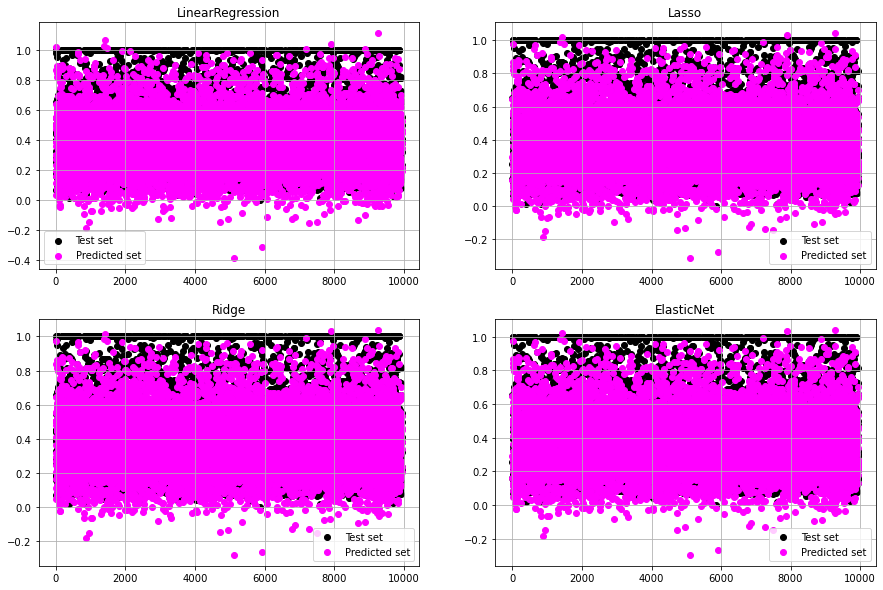

In [816]:
plt.figure(figsize=(15, 10))
for j in range(len(predictions)):
    plt.subplot(2, 2, j+1)
    i+=1
    plt.title(f'{titles[j]}')
    plt.scatter([i for i in range(len(y_test))], y_test, color = 'black', label = 'Test set')
    plt.scatter([i for i in range(len(y_test))], predictions[j], color = 'magenta', label = 'Predicted set')
    plt.legend()
    plt.grid()

Ensemble

In [817]:
def ensemble(true_y, predictions):
    pred_final = (np.mean(predictions, axis=0))
    return pred_final

Prediction accuracy:  0.6579396791164235


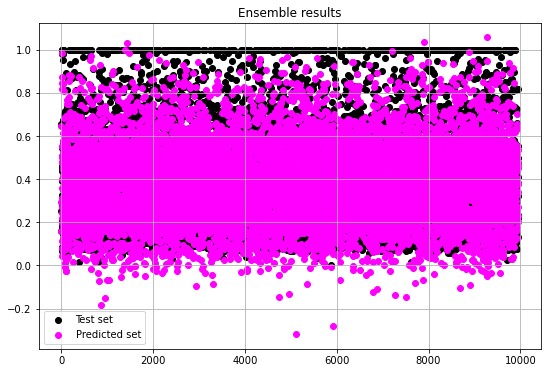

In [818]:
pred_final = ensemble(y_test, [pred, Lasso_pred, Ridge_pred, ElasticNet_pred])
fig, ax = plt.subplots(figsize = (9, 6))
print('Prediction accuracy: ', r2_score(y_test, pred_final))
plt.title('Ensemble results')
plt.scatter([i for i in range(len(y_test))], y_test,color = 'black', label = 'Test set')
plt.scatter([i for i in range(len(y_test))], pred_final, color = 'magenta', label = 'Predicted set')
plt.legend()
plt.grid()
plt.show()